In [11]:
import numpy as np
import matplotlib.pyplot as plt
import random

from math import gcd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import load_model

In [ ]:
# Criação de dados
def create_data(options):
  data = []

  if options == 1:
    while len(data) < 1000000:
      a = np.random.randint(1, 101)
      b = np.random.randint(1, 101)
      data.append([a, b, gcd(a, b)])

  elif options == 2:
    for i in range(1, 101):
      for j in range(1, 101):
        data.append([i, j, gcd(i, j)])
    
    random.shuffle(data)
    
    # Dividir os dados em três partes e Expande os dados 
    first_half_size = len(data) // 2 # 50% para treinamento
    second_quarter_size = len(data) // 4 # 25% para validação e teste

    train_data = data[ : first_half_size] * 100
    validation_data = data[first_half_size : first_half_size + second_quarter_size] * 100
    test_data = data[first_half_size + second_quarter_size : ] * 100

    random.shuffle(train_data)
    random.shuffle(validation_data)

    data = train_data + validation_data + test_data

  # Escreve todos os dados em um arquivo
  with open("txt_files/new_data.txt", "w") as f:
    for item in data:
      f.write("\t".join(map(str, item)) + "\n")

In [ ]:
def load_data(file_path):
  with open(file_path, "r") as f:
    data = [line.strip().split("\t") for line in f.readlines()]

  y_in = np.array([[int(d[0]), int(d[1])] for d in data])
  mdc = np.array([int(d[2]) for d in data])

  # Primeira divisão entre treinamento e validação
  y_train, y_validation, mdc_train, mdc_validation = train_test_split(y_in, mdc, test_size=0.5, shuffle=False)
  # Segunda divisão dentro do conjunto de validação, entre validação e teste
  y_validation, y_test, mdc_validation, mdc_test = train_test_split(y_validation, mdc_validation, test_size=0.5, shuffle=False)

  return y_train, y_validation, y_test, mdc_train, mdc_validation, mdc_test

def check_data(check_array, array_1, array_2):
  # Converter array_1 e array_2 para conjuntos
  set_array_1 = set(map(tuple, array_1))
  set_array_2 = set(map(tuple, array_2))

  dados_repetidos = 0

  # Verificar se os dados de check_array estão em set_array_1 ou set_array_2
  for i in map(tuple, check_array):
    if i in set_array_1 or i in set_array_2:
      dados_repetidos += 1

  print(f"Total de dados repetidos: {dados_repetidos}")

def delete_duplicate_ordanate(array):
  # Converte o array numpy para uma lista de tuplas e depois para um conjunto para remover duplicatas
  unique_set = set(map(tuple, array))
  # Converte o conjunto de volta para um array numpy
  unique_array = np.array(list(unique_set))

  # Organizada o array em ordem crescente
  sorted_indices = np.lexsort((unique_array[:,1], unique_array[:,0]))
  sorted_array = unique_array[sorted_indices]
  
  return np.array(sorted_array)

In [ ]:
# Opção 1 cria dados repetidos / Opção 2 cria dados diferentes para cada conjunto
# Total de dados: 1.000.000
option = 2
create_data(option)

In [ ]:
y_train, y_validation, y_test, mdc_train, mdc_validation, mdc_test = load_data("txt_files/new_data.txt")

check_data(y_train, y_validation, y_test)
check_data(y_validation, y_train, y_test)
check_data(y_test, y_train, y_validation)

print(len(y_train), len(y_validation), len(y_test))

In [ ]:
#Rede Neural
model = Sequential([
  Embedding(input_dim=201, output_dim=64), # Camada de entrada
  LSTM(64, return_sequences=True),
  LSTM(64, return_sequences=True),
  LSTM(64),
  Dense(1) # Camada de saída
])

# Compilar o modelo
model.compile(optimizer = "adam", loss= "mean_squared_error", metrics=["accuracy"])

# Callback para parar o treinamento se a métrica monitorada não melhorar
early_stopping = EarlyStopping(monitor="loss", patience=10)

#Treina o modelo
history = model.fit(y_train, mdc_train, epochs=500, batch_size=512, verbose=1, callbacks=[early_stopping], validation_data=(y_validation, mdc_validation))

In [16]:
import pickle

# Salva modelo treinado
# model.save("modelos_historico/NOME.keras")

# Salva o histórico
# with open("modelos_historico/NOME.pkl", "wb") as file:
#   pickle.dump(history.history, file)

# Carrega modelo treinado
# model = load_model("modelos_historico/NOME.keras")

# Carregar o histórico
with open("modelos_historico/different_data.pkl", "rb") as file:
  history = pickle.load(file)

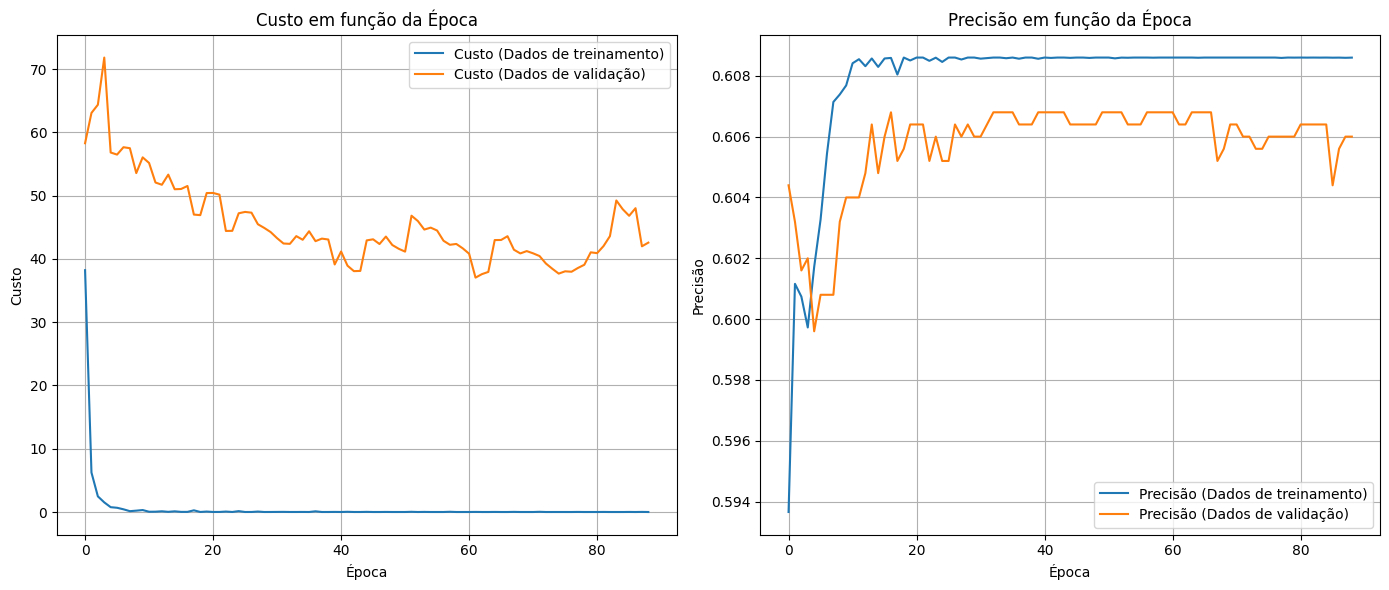

In [17]:
# Criar a figura e os subplots
fig, axs = plt.subplots(1,2, figsize=(14, 6))

# Plotar o gráfico da CUSTO em função da época
axs[0].plot(history['loss'], label="Custo (Dados de treinamento)")
axs[0].plot(history['val_loss'], label="Custo (Dados de validação)")
axs[0].set_title('Custo em função da Época')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Custo')
axs[0].legend(loc="upper right")
axs[0].grid(True)

# Plotar o gráfico da PRECISÃO em função da época
axs[1].plot(history["accuracy"], label="Precisão (Dados de treinamento)")
axs[1].plot(history['val_accuracy'], label="Precisão (Dados de validação)")
axs[1].set_title('Precisão em função da Época')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Precisão')
axs[1].legend(loc="lower right")
axs[1].grid(True)

# Ajustar o layout
plt.tight_layout()

# Mostrar a figura
plt.show()

In [ ]:
new_y_test = delete_duplicate_ordanate(y_test)
new_mdc_test = []

for i in new_y_test:
  new_mdc_test.append( gcd(i[0], i[1]) )

predictions = model.predict(new_y_test)
rounded_predictions = np.round(predictions).astype(int)

In [ ]:
correct_value = 0
wrong_predictions = []

for i in range(len(new_y_test)):
  if (rounded_predictions[i] == new_mdc_test[i]):
    correct_value += 1
  else:
    wrong_predictions.append(f"MDC de {[new_y_test[i][0], new_y_test[i][1]]} - Previsto: {rounded_predictions[i][0], predictions[i][0]} - Real: {new_mdc_test[i]}")

print(f"Dados (teste): {len(new_y_test)}")
print(f"Acertos: {correct_value}")
print(f"Erros: {len(wrong_predictions)}")

print(f"Precisão: {((correct_value/len(new_y_test)) * 100):.2f}%")

# with open("txt_files/previsões_erradas_dados_diferentes.txt", "w") as f:
#   for i in range(len(wrong_predictions)):
#     f.write(wrong_predictions[i] + "\n")

In [ ]:
""" # Salva algumas predições erradas da rede neural
import re

# Definindo as duplas de dados
select_data = [[5, 20],[6, 44],[6, 88],[10, 100],[11, 11],[12, 3],[30, 12],[20,100],[24,6],[99,100],[96,16]]
# Convertendo a lista de listas em um numpy array
select_data = np.array(select_data)

with open("dados_selecionados.txt", "w") as f:
  for i in wrong_predictions:
    match = re.search(r'\[([^\]]+)\]', i)
    
    if match:
      extracted_text = (match.group(1)).split(', ')
      int_data = np.array([int(num) for num in extracted_text])
      is_present =  np.any(np.all(select_data == int_data, axis=1))
      if is_present:
        f.write(i + " || " + f"MDC de {[int_data[1], int_data[0]]} - Previsto: {model.predict(np.array([[int_data[1], int_data[0]]]))[0]} - Real: {gcd(int_data[1], int_data[0])}"+ "\n")  """

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Obtém os pesos e bias da camada de Embedding
embedding_weights = model.layers[0].get_weights()[0]

# Obtém os pesos e bias da primeira camada LSTM
lstm1_weights, lstm1_recurrent_weights, lstm1_bias = model.layers[1].get_weights()

# Obtém os pesos e bias da segunda camada LSTM
lstm2_weights, lstm2_recurrent_weights, lstm2_bias = model.layers[2].get_weights()

# Obtém os pesos e bias da terceira camada LSTM
lstm3_weights, lstm3_recurrent_weights, lstm3_bias = model.layers[3].get_weights()

# Obtém os pesos e bias da camada densa
dense_weights, dense_bias = model.layers[4].get_weights()

# Função para plotar heatmaps em subplots
def plot_weights_and_biases(weights, bias, title_weights, title_bias):
  plt.figure(figsize=(14, 6))

  # Plot weights
  plt.subplot(1, 2, 1)
  sns.heatmap(weights, cmap="viridis", linewidths=.5)
  plt.title(title_weights)

  # Plot bias
  plt.subplot(1, 2, 2)
  sns.heatmap(bias.reshape(1, -1), cmap="viridis", linewidths=.5)
  plt.title(title_bias)

  plt.tight_layout()
  plt.show()

# Mapa de calor dos pesos e bias da camada de Embeddingc
plot_weights_and_biases(embedding_weights, embedding_weights.mean(axis=0), 'Embedding Layer Weights', 'Embedding Layer Bias')

# Mapa de calor dos pesos e bias da primeira camada LSTM
plot_weights_and_biases(lstm1_weights, lstm1_bias, 'LSTM 1 Weights', 'LSTM 1 Bias')

# Mapa de calor dos pesos e bias da segunda camada LSTM
plot_weights_and_biases(lstm2_weights, lstm2_bias, 'LSTM 2 Weights', 'LSTM 2 Bias')

# Mapa de calor dos pesos e bias da terceira camada LSTM
plot_weights_and_biases(lstm3_weights, lstm3_bias, 'LSTM 3 Weights', 'LSTM 3 Bias')

# Mapa de calor dos pesos e bias da camada densa
plot_weights_and_biases(dense_weights, dense_bias, 'Dense Layer Weights', 'Dense Layer Bias')
